<div class="alert alert-block alert-info">
<font size="5"><b><center> Section 5</font></center>
<br>
<font size="5"><b><center>Recurrent Neural Network in PyTorch with an Introduction to Natural Language Processing</font></center>
</div>

# Simple Text Processing

## Typically Data Preprocessing Steps before Modeling Training for NLP Applications

* Read the data from disk
* Tokenize the text
* Create a mapping from word to a unique integer
* Convert the text into lists of integers
* Load the data in whatever format your deep learning framework requires
* Pad the text so that all the sequences are the same length, so you can process them in batch

In [ ]:
thor_review = "the action scenes were top notch in this movie. Thor has never been this epic in the MCU. He does some pretty epic sh*t in this movie and he is definitely not under-powered anymore. Thor in unleashed in this, I love that."

In [ ]:
word_embedding = "word embeddings are a representation of the *semantics* of a word, efficiently encoding semantic information that might be relevant to the task at hand"

In [ ]:
print(list(word_embedding))

## Converting text into words

In [ ]:
print(word_embedding.split())

## N-grams and NLTK

In [ ]:
from nltk import ngrams

In [ ]:
print(list(ngrams(word_embedding.split(),2)))

- `n-grams` is used in many supervised machine learning models, such as Naive Bayes, to improve feature space. 

- `n-grams` are also used for spelling correction and text-summarization tasks.

- Limitation of `n-grams` representation: it loses the sequential nature of text

**Do one-hot encoding using canned functions**

A major limitation of the one-hot representation is that the data is too sparse, because the size of the vector quickly grows as the number of unique words in the vocabulary increases. As such, this representation is not typically used in deep learning.

## Word Embedding

Word embedding is a very popular way of representing text data in problems that are solved by deep learning algorithms

Word embedding provides a dense representation of a word filled with floating numbers. 

It drastically reduces the dimension of the dictionary



###  `Torchtext` and Training word embedding by building a sentiment classifier

Torchtext takes a declarative approach to loading its data: 

  * you tell torchtext how you want the data to look like, and torchtext handles it for you
  
  * Declaring a Field: The Field specifies how you want a certain field to be processed
  
The `Field` class is a fundamental component of torchtext and is what makes preprocessing very easy



### Load  Car Review into `torchtext.data`

In [1]:
# pip install torchtext
from torchtext import data, datasets
from torchtext.vocab import GloVe,FastText,CharNGram

import pandas as pd
import numpy as np
import re
import string
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from nltk.tokenize import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torch

* Define two `Field` objects for the actual texts and the labels.

* For the actual texts, `torchtext` will lowercase, tokenize, and trim the text to a maximum length of 20. We could change the maximum length of the text to other numbers.

In [2]:
#Load Subaru data
review_df = pd.read_csv("data/Section5/car_review.csv")

In [3]:
review_df.info

<bound method DataFrame.info of                                             review_text label
0     Just bot a 2018 Forester with cvt transmission...   neg
1     This is the noisiest car I  have ever owned.  ...   neg
2     Hello. My name is Steve and I recently purchas...   neg
3     Subaru prominently displays, on the console sc...   neg
4     My wife leased a 2016 model and within 6 mths ...   neg
5     I ordered a toyota RAV4 but got a Forrester fr...   neg
6     I purchased this vehicle because of Subaru's r...   neg
7     My 2017 Forester XT Touring model has been one...   neg
8     This is our 4th Subaru. Previously owned Impre...   neg
9     Drives [non-permissible content removed] in cr...   neg
10    Purchased 2017 Forester in October of 2016 at ...   neg
11    2017 Forester 2.0 XT- I have had the radio in ...   neg
12    The CVT transmission makes for a driving exper...   neg
13    Updated 10k mile review                       ...   neg
14    This is my second Forester. Last

In [4]:
review_df.head()
review_df.shape

,review_text,label
0,Just bot a 2018 Forester with cvt transmission...,neg
1,This is the noisiest car I have ever owned. ...,neg
2,Hello. My name is Steve and I recently purchas...,neg
3,"Subaru prominently displays, on the console sc...",neg
4,My wife leased a 2016 model and within 6 mths ...,neg


(1524, 2)

In [5]:
#Word count describe stats for review text
review_df.review_text.apply(lambda x: len(x)).describe()

count    1524.000000
mean      734.421260
std       780.839384
min         9.000000
25%       227.750000
50%       493.000000
75%       956.500000
max      5817.000000
Name: review_text, dtype: float64

In [6]:
#Split DF csv to training and testing data

def prepare_csv(df_file, text_clm, label_clm, test_ratio, seed):
    """
    Split review_df to training and testing sets as csv 
    
    Arguments:
    df_file, the full dataset csv about to be split
    text_clm, the column name of the text in csv
    label_clm, the column name of the label in csv
    val_ration, validation set ratio to the overall data
    seed, randmoization seed
    
    Return:
    save train and test csv files under data/Section5/cache folder
    """
    
    #Read file
    full_df = pd.read_csv(df_file)
    
    #shuffle index
    idx = np.arange(full_df.shape[0])
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    #test set size
    test_size = int(len(idx) * test_ratio)
    
    #Save train and test csv under cache folder
    full_df.iloc[idx[test_size:], :].to_csv("data/Section5/cache/training.csv", index = False)
    full_df.iloc[idx[:test_size], :].to_csv("data/Section5/cache/testing.csv", index = False)
    
    #Print size of trainig and testing data
    print("training set size: " + str(len(idx[test_size:])))
    print("testing set size: " + str(len(idx[:test_size]))) 

In [7]:
#Define tokenizer function for the Text data field
def tokenizer(comment):
    """
    Tokenize reviews without punctuation and non-text signs
    
    Arguments:
    String text
    
    Returns:
    Tokenized clean words
    
    """
    comment = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(comment))
    comment = re.sub(r"[ ]+", " ", comment)
    comment = re.sub(r"\!+", "!", comment)
    comment = re.sub(r"\,+", ",", comment)
    comment = re.sub(r"\?+", "?", comment)
    
    return [x for x in word_tokenize(comment) if x not in string.punctuation]

## Build Train and Text `torch.data.TabularDataset`

In [9]:
#Split Train and Test
prepare_csv("data/Section5/car_review.csv", "review_text", "label", 0.3, 42)

#construct field
TEXT = data.Field(sequential=True, fix_length=300, tokenize=tokenizer, pad_first=True,
    #tensor_type=torch.cuda.LongTensor, 
                  lower=True, batch_first = True)

LABEL = data.Field(sequential = False)

#Build training and testing datasets
train = data.TabularDataset(path='data/Section5/cache/training.csv', format='csv', skip_header=True,
    fields=[('review_text', TEXT),
        ('label', LABEL),
    ])
test = data.TabularDataset(path='data/Section5/cache/testing.csv', format='csv', skip_header=True,
    fields=[('review_text', TEXT),
        ('label', LABEL),
    ])

training set size: 1067
testing set size: 457


- **Read in car_review.csv and split it ito train and test datasets**

- The following command abstracts away all the complexity involved in downloading, tokenizing, and splitting the database into train and test datasets

- Torch comes with datasets to play with; e.g. IMDB datasets. `torch.datasets` come with many datasets, such as `IMDB` for sentiment analysis, `TREC` for question classification, `WikiText-2` for language modeling, etc.

- For tokenization, `NLTK` can also be specified

In [10]:
#Number of training and testing reviews
len(train), len(test)

(1067, 457)

In [11]:
train.fields['review_text']

`train.fields` contains a dictionary where `TEXT` is the key and the `value` LABEL

In [12]:
type(train.fields)

dict

In [13]:
print('train.fields', train.fields)

train.fields {'review_text': <torchtext.data.field.Field object at 0x1105d1d68>, 'label': <torchtext.data.field.Field object at 0x1105d1e48>}


In [14]:
train.fields.keys()

dict_keys(['review_text', 'label'])

In [15]:
len(train.fields)

2

In [16]:
train.fields.values()

dict_values([<torchtext.data.field.Field object at 0x1105d1d68>, <torchtext.data.field.Field object at 0x1105d1e48>])

In [17]:
train.fields.items()

dict_items([('review_text', <torchtext.data.field.Field object at 0x1105d1d68>), ('label', <torchtext.data.field.Field object at 0x1105d1e48>)])

In [18]:
type(train)

torchtext.data.dataset.TabularDataset

In [19]:
len(train[0].review_text),
vars(train[120])

(27,)

{'label': 'pos',
 'review_text': ['fair',
  'warning',
  'this',
  'review',
  'is',
  'long',
  'intended',
  'to',
  'provide',
  'the',
  'kind',
  'of',
  'consumer',
  'details',
  'that',
  'professional',
  'reviewers',
  'won',
  't',
  'notice',
  'in',
  'their',
  'few',
  'hours',
  'with',
  'a',
  'car',
  'i',
  'generally',
  'agree',
  'with',
  'the',
  'professional',
  'reviews',
  'and',
  'if',
  'only',
  'looking',
  'for',
  'a',
  '30',
  'second',
  'summary',
  'my',
  'review',
  'is',
  'not',
  'for',
  'you',
  'we',
  've',
  'owned',
  'our',
  '2018',
  'highlander',
  'hybrid',
  'awd',
  'limited',
  'platinum',
  'about',
  'a',
  'month',
  'now',
  'other',
  'contenders',
  'included',
  'a',
  'lexus',
  'rxl',
  'audi',
  'q7',
  'acura',
  'mdx',
  'and',
  'honda',
  'pilot',
  'while',
  'never',
  'unimportant',
  'price',
  'was',
  'not',
  'the',
  'top',
  'concern',
  'and',
  'we',
  'bought',
  'which',
  'one',
  'we',
  'like',
  

## Buidling a vocabulary

The `torchtext` facilitate the creation of a dictionary from a corpus of text. Once a dataset is loaded, we can call `build_vocab` and pass the necessary arguments that will handle building the vocabulary for the data. 

For instance, in the code below, we can initialize vectors with `pretrained embeddings of dimensions 300`

In [20]:
#Build Vocabulary with Glove
TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=300),max_size=10000,min_freq=5)
LABEL.build_vocab(train,)

Once the vocabulary is built, we can obtain different values such as 
    * frequency
    * word index
    * vector representation for each word

In [21]:
print(TEXT.vocab.vectors)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
        ...,
        [ 0.2170,  0.1269,  0.0100,  ..., -0.1150,  0.1451,  0.2490],
        [-0.3212,  0.0243, -0.4958,  ...,  0.3266, -0.1780,  0.0385],
        [-0.4707, -0.1889,  0.4442,  ...,  0.1091,  0.0852, -0.3858]])


In [22]:
TEXT.vocab.vectors.shape

torch.Size([2308, 300])

In [23]:
TEXT.vocab.vectors[3].shape

torch.Size([300])

In [24]:
TEXT.vocab.vectors[234]

tensor([-4.0578e-01,  1.9104e-01, -4.4478e-02, -3.7596e-01, -5.2203e-02,
         1.5818e-01, -2.1864e-01, -4.9750e-01,  1.6392e-01, -1.1630e+00,
        -1.3035e-01,  1.4735e-03,  2.0038e-01,  8.1595e-02, -1.8067e-01,
         3.2417e-01, -1.6932e-01, -1.2512e-01, -1.8244e-01, -2.7191e-02,
         4.8280e-02,  2.4737e-01,  3.1848e-02,  4.9044e-03,  5.5381e-02,
        -8.6290e-02,  3.9594e-01, -2.7219e-01,  2.3002e-01, -4.9137e-02,
         6.0252e-02,  6.1103e-03, -3.0469e-01,  2.3875e-01, -9.8352e-01,
         6.5970e-01, -2.6383e-01, -2.2272e-02, -4.1187e-01, -4.6430e-01,
        -4.8265e-01, -1.9175e-01, -3.0197e-01,  2.2805e-01,  3.1041e-01,
         2.0822e-01,  3.7355e-01, -5.6587e-02, -4.2424e-01, -2.0329e-01,
         8.1730e-02, -2.4428e-01, -2.6057e-01, -2.6239e-01,  4.2559e-02,
        -2.3757e-01, -2.7585e-01,  2.7059e-01,  2.4546e-01, -1.9692e-03,
         1.6270e-01, -2.5354e-01,  3.6625e-01,  4.2124e-01, -1.9516e-02,
        -7.6441e-01,  3.1708e-01, -4.8911e-01, -2.1

In [25]:
print(TEXT.vocab.stoi)

defaultdict(<function _default_unk_index at 0x124f71d08>, {'<unk>': 0, '<pad>': 1, 'the': 2, 'i': 3, 'and': 4, 'a': 5, 'to': 6, 'it': 7, 'is': 8, 'in': 9, 'of': 10, 'car': 11, 'this': 12, 'for': 13, 'my': 14, 'have': 15, 'with': 16, 'on': 17, 'that': 18, 'not': 19, 'was': 20, 'but': 21, 'you': 22, 'we': 23, 'they': 24, "n't": 25, 'honda': 26, 'vehicle': 27, 'are': 28, 'at': 29, 'had': 30, 'has': 31, 'so': 32, "'s": 33, 'when': 34, 'as': 35, 'very': 36, 'be': 37, 'me': 38, 'do': 39, 'all': 40, 'new': 41, 'like': 42, 'transmission': 43, 'or': 44, 'great': 45, 'will': 46, 'from': 47, 'no': 48, 'get': 49, 'if': 50, 'out': 51, 'up': 52, 'would': 53, 'drive': 54, 'miles': 55, 'back': 56, 'one': 57, 'about': 58, 'can': 59, 'just': 60, 'there': 61, 'after': 62, 'an': 63, 'am': 64, 'driving': 65, 'than': 66, 'only': 67, 'been': 68, 'more': 69, 'time': 70, 'good': 71, 'jeep': 72, 'pilot': 73, 'dealer': 74, 'our': 75, 'also': 76, 'love': 77, 'which': 78, 'forester': 79, 'subaru': 80, 'did': 81, '

### Batching

`Torchtext` provides `BucketIterator`, which helps in batching all the text and replacing the words with the index number of the words.

* The `BucketIterator` instance comes with a lot of useful parameters like `batch_size`, `device` (GPU or CPU), and `shuffle`.

In [26]:
train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size=128, device=-1,shuffle=True)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


**Create a batch**

In [27]:
batch = next(iter(train_iter))
print(batch.review_text.shape)
print(batch.label.shape)

# batch_size x fix_len
batch.review_text
batch.label

torch.Size([128, 300])
torch.Size([128])


tensor([[   3,  100,    5,  ...,  308,   10,  200],
        [   1,    1,    1,  ..., 1729, 1608, 1148],
        [   1,    1,    1,  ...,    5,    0,   96],
        ...,
        [   1,    1,    1,  ...,    5,    0,    0],
        [   1,    1,    1,  ...,  255, 1584,  158],
        [   1,    1,    1,  ...,  172,    0, 1009]])

tensor([2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1,
        1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2,
        1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2,
        2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2,
        2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2,
        1, 2, 2, 2, 2, 2, 1, 2])

## Create a network with Word Embedding

# Use LSTM for Sentiment Classification

1. Preparing the data (previous steps)
2. Creating the batches 
3. Creating the network 
4. Training the model

In [28]:
#Split Train and Test
prepare_csv("data/Section5/car_review.csv", "review_text", "label", 0.3, 42)

#construct field
TEXT = data.Field(sequential=True, fix_length=200, tokenize=tokenizer,# pad_first=True,
                  lower=True, batch_first = False)

LABEL = data.Field(sequential = False,)

#Build training and testing datasets
train = data.TabularDataset(path='data/Section5/cache/training.csv', format='csv', skip_header=True,
    fields=[('review_text', TEXT),
        ('label', LABEL),
    ])
test = data.TabularDataset(path='data/Section5/cache/testing.csv', format='csv', skip_header=True,
    fields=[('review_text', TEXT),
        ('label', LABEL),
    ])

#Build dictionary 
TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=300),max_size=10000, min_freq=5)
LABEL.build_vocab(train,)

training set size: 1067
testing set size: 457


In [29]:
#Break train, test data into batches(size 32)
train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size=32, device=-1, sort_key = lambda x: len(x.review_text), sort_within_batch = False)
train_iter.repeat = False
test_iter.repeat = False

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [30]:
class IMDBRnn(nn.Module):
    
    def __init__(self,vocab,hidden_size,n_cat,bs=1,nl=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.bs = bs
        self.nl = nl
        self.e = nn.Embedding(n_vocab,hidden_size)
        self.rnn = nn.LSTM(hidden_size,hidden_size,nl)
        self.fc2 = nn.Linear(hidden_size,n_cat)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self,inp):
        bs = inp.size()[1]
        if bs != self.bs:
            self.bs = bs
        e_out = self.e(inp)
        h0 = c0 = Variable(e_out.data.new(*(self.nl,self.bs,self.hidden_size)).zero_())
        rnn_o,_ = self.rnn(e_out,(h0,c0))
        rnn_o = rnn_o[-1]
        fc = F.dropout(self.fc2(rnn_o),p=0.50)
        return self.softmax(fc)

In [36]:
n_vocab = len(TEXT.vocab)
n_hidden = 64

In [37]:
model = IMDBRnn(n_vocab,n_hidden,3,bs=32)
#model = model.cuda()

optimizer = optim.Adam(model.parameters(),lr=1e-3)

def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , batch in enumerate(data_loader):
        text,target = batch.review_text , batch.label
#         if is_cuda:
#             text,target = text.cuda(),target.cuda()
        
        if phase == 'training':
            optimizer.zero_grad()
        output = model(text)
        
        loss = F.nll_loss(output, target)
        
        running_loss += F.nll_loss(output,target,size_average=False).data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    print("loss: ", loss, "accuracy: ", accuracy)
    #print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [38]:
import time
start = time.time()

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]

for epoch in range(1,25):
    print("epoch:" + str(epoch) )
    epoch_loss, epoch_accuracy = fit(epoch,model,train_iter,phase='training')
    val_epoch_loss, val_epoch_accuracy = fit(epoch,model,test_iter,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
end = time.time()
print((end-start)/60)
print("Execution Time: ", round(((end-start)/60),1), "minutes")

epoch:1


/Users/jeffrey/anaconda2/envs/dl/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loss:  tensor(0.9465) accuracy:  tensor(50)
loss:  tensor(0.8939) accuracy:  tensor(52)
epoch:2
loss:  tensor(0.9036) accuracy:  tensor(47)
loss:  tensor(0.8881) accuracy:  tensor(49)
epoch:3
loss:  tensor(0.8735) accuracy:  tensor(48)
loss:  tensor(0.8664) accuracy:  tensor(55)
epoch:4
loss:  tensor(0.8713) accuracy:  tensor(50)
loss:  tensor(0.8808) accuracy:  tensor(54)
epoch:5
loss:  tensor(0.8759) accuracy:  tensor(52)
loss:  tensor(0.8356) accuracy:  tensor(55)
epoch:6
loss:  tensor(0.8558) accuracy:  tensor(51)
loss:  tensor(0.8734) accuracy:  tensor(52)
epoch:7
loss:  tensor(0.8403) accuracy:  tensor(54)
loss:  tensor(0.8702) accuracy:  tensor(52)
epoch:8
loss:  tensor(0.8190) accuracy:  tensor(57)
loss:  tensor(0.8740) accuracy:  tensor(54)
epoch:9
loss:  tensor(0.8165) accuracy:  tensor(55)
loss:  tensor(0.9051) accuracy:  tensor(48)
epoch:10
loss:  tensor(0.7985) accuracy:  tensor(57)
loss:  tensor(0.8988) accuracy:  tensor(50)
epoch:11
loss:  tensor(0.7897) accuracy:  tenso

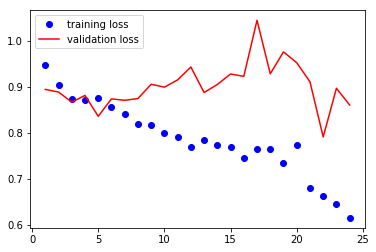

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

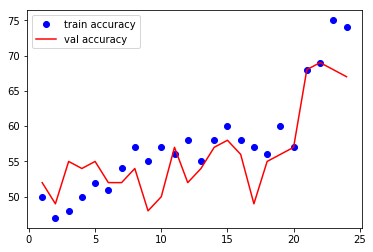

In [40]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()